# Critical gradient optimization #

This notebook shows how to run optimizations on the effective radius in DESC. This also orks for the parallel connection length but not enough testing has been done on it

Notes : 
1. It is possible that an optimization might not work, because of the creation of little wells in the drift curvature profile which make calculating the effective radius more complicated. This is still to be resolved
2. The entire notebook should run, gpu highly recommended

## Imports ##

Uncomment if GPU available

In [1]:
from desc import set_device
# set_device("cpu")
set_device("gpu")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from desc.backend import jnp
from desc.examples import get
import desc.io
from desc.equilibrium import EquilibriaFamily
from desc.grid import LinearGrid, QuadratureGrid
from desc.equilibrium.coords import get_rtz_grid
from desc.objectives import (
    AspectRatio,
    FixBoundaryR,
    FixBoundaryZ,
    FixCurrent,
    FixPressure,
    FixPsi,
    FixIonTemperature,
    FixElectronTemperature,
    FixElectronDensity,
    FixAtomicNumber,
    ForceBalance,
    ObjectiveFunction,
    EffectiveRadius,
    ParallelConnectionLength,
    QuasisymmetryTwoTerm,
)
from desc.optimize import Optimizer
from desc.plotting import (
    plot_comparison,
    plot_section,
    plot_surfaces,
    plot_boundaries,
    plot_boozer_surface,
    plot_boozer_surface,
    plot_boundary,
    plot_qs_error,
)

from desc.vmec import VMECIO

DESC version 0.12.3+146.gb1f772e95.dirty,using JAX backend, jax version=0.4.30, jaxlib version=0.4.30, dtype=float64
Using device: NVIDIA A100-SXM4-40GB (id=0), with 40.00 GB available memory


2024-11-20 14:00:31.160193: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Methods ##

### General ###

In [3]:
# Function to get value of a parameter directly
def get_value(eq, name, grid):
    return eq.compute(name, grid=grid)[name]


# Function to get the straight field line coordinate system, need iota for jit
def get_field_line_grid(eq, iota, rho=0.5, alpha=0, n_pol=4, n_points=200):
    n_tor = jnp.abs(n_pol / iota)
    good_grid = get_rtz_grid(
        eq,
        jnp.array(rho),
        # np.array(rho),
        jnp.array(alpha),
        # np.linspace(0,2*n_tor*np.pi,n_points*n_pol),
        jnp.linspace(0, 2 * n_tor * jnp.pi, n_points * n_pol),
        coordinates="raz",
        iota=iota,
        period=(jnp.inf, 2 * jnp.pi, jnp.inf),
    )
    return good_grid

In [4]:
# Function for plotting the drift curvature profile and calculate effective radius and parallel connection length
def plot_Kd(eq, n_pol=11, rho=0.5, n_wells=5):
    iota_grid = LinearGrid(rho=rho)
    iota = jnp.abs(eq.compute("iota", iota_grid)["iota"][0])
    grid = get_field_line_grid(eq, iota, n_pol=n_pol, rho=rho)
    Kd = get_value(eq, "Kd", grid)
    plt.figure()
    plt.plot(grid.nodes[:, 2], Kd)
    plt.axhline(0, color="r", linestyle="--")
    plt.xlabel(r"$\zeta$")
    plt.ylabel(r"$K_d$")
    R_eff = eq.compute("R_eff", grid=grid, n_wells=n_wells)["R_eff"]
    L_par = eq.compute("L_par", grid=grid, n_wells=n_wells)["L_par"]
    a = get_value(eq, "a", grid)

    # Format the text to be displayed in the box
    textstr = (
        f"Mean value of $a/R_{{eff}}$: {a/R_eff.mean():.3f}\n"
        f"Mean value of $a/L_{{par}}$: {a/L_par.mean():.3f}\n"
        f"Minimum value of $a/R_{{eff}}$: {a/R_eff.max():.3f}\n"
        f"Minimum value of $a/L_{{par}}$: {a/L_par.max():.3f}\n"
    )

    # Add the text box to the plot
    props = dict(boxstyle="round", facecolor="white", alpha=0.5)
    plt.text(
        0.05,
        0.95,
        textstr,
        transform=plt.gca().transAxes,
        fontsize=12,
        verticalalignment="top",
        bbox=props,
    )

    # Add a legend and show the plot
    # plt.legend()
    plt.show()

    # Print the values for verification
    print(f"Values of R_eff are: {R_eff}")
    print(f"Values of L_par are: {L_par}")
    return grid, R_eff, L_par

In [5]:
# Function to check force error
def check_force_error(eq):
    grid = QuadratureGrid(eq.L_grid, eq.M_grid, eq.N_grid, eq.NFP)
    data = eq.compute(["p", "sqrt(g)", "|F|", "|grad(|B|^2)|/2mu0"], grid)
    err = jnp.sum(data["|F|"] * data["sqrt(g)"] * grid.weights) / jnp.sum(
        data["|grad(|B|^2)|/2mu0"] * data["sqrt(g)"] * grid.weights
    )
    print("eq error: {:.2f}%".format(err * 1e2))

### Optimizations ###

In [6]:
def run_step_weights(
    k, eq, target = False, qs_weight=5.0, ar_weight=5.0, n_wells=5, n_pol=11):
    """
    Run a step of the optimization with weights, targeting effective radius, quasisymmetry and aspect ratio

    Parameters:
    - k: Threshold for the modes to fix.
    - eq: Initial DESC equilibrium object.
    - target : whether to fix all modes except k or fix all modes above k. If True fixes all except k mode number modes
    - qs_weight: Weight for the quasisymmetry term.
    - ar_weight: Weight for the aspect ratio term.
    - n_wells: Number of wells for effective radius optimization.
    - n_pol: Number of poloidal turns.

    Returns:
    - eq_new: Optimized equilibrium object.
    """
    # Create grid for minimizing quasisymmetry error
    grid = LinearGrid(
        M=eq.M_grid, N=eq.N_grid, NFP=eq.NFP, rho=jnp.array([0.6, 0.8, 1.0]), sym=True
    )

    # Create an ObjectiveFunction with weights
    objective = ObjectiveFunction(
        (
            QuasisymmetryTwoTerm(eq=eq, helicity=(1, 0), grid=grid, weight=qs_weight),
            EffectiveRadius(eq=eq, n_wells=n_wells, n_pol=n_pol),
            AspectRatio(eq=eq, target=6, weight=ar_weight),
            # ParallelConnectionLength(eq=eq,n_wells=n_wells,n_pol=n_pol),
        ),
    )
    
    # operation function to be able to target a specific mode or all modes above a threshold
    operation = (lambda x: x != k) if target else (lambda x: x > k)
    
    # Calculate the maximum value array once
    R_max = jnp.max(jnp.abs(eq.surface.R_basis.modes), 1)
    Z_max = jnp.max(jnp.abs(eq.surface.Z_basis.modes), 1)

    # Apply the operation
    R_modes = jnp.vstack(
        (
            [0, 0, 0],
            eq.surface.R_basis.modes[operation(R_max), :],
        )
    )
    Z_modes = eq.surface.Z_basis.modes[operation(Z_max), :]

    # Create constraints
    constraints = (
        ForceBalance(eq=eq),
        FixBoundaryR(eq=eq, modes=R_modes),
        FixBoundaryZ(eq=eq, modes=Z_modes),
        FixPressure(eq=eq),
        FixCurrent(eq=eq),
        FixPsi(eq=eq),
        ## Comment pressure and uncomment the 4 below if the pressure profile is not fixed ##
        # FixIonTemperature(eq=eq),
        # FixElectronTemperature(eq=eq),
        # FixElectronDensity(eq=eq),
        # FixAtomicNumber(eq=eq),
    )

    # Default optimizer
    optimizer = Optimizer("proximal-lsq-exact")

    # Optimize equilibrium
    eq_new, _ = eq.optimize(
        objective=objective,
        constraints=constraints,
        optimizer=optimizer,
        maxiter=20,
        verbose=3,
        copy=True,
        options={
            "initial_trust_ratio": 1.0,
        },
    )
    return eq_new

In [7]:
def run_step_weights_fam(
    k, eqfam, target = False, qs_weight=5.0, ar_weight=5.0, n_wells=5, n_pol=11):
    """
    Run a step of the optimization with weights, with input as equilibrium family, useful for continuiton type optimization

    Parameters:
    - k: Threshold for the modes to fix.
    - eqfam: Equilibrium family
    - target : whether to fix all modes except k or fix all modes above k. If True fixes all except k mode number modes
    - method: Optimization method for DESC.
    - qs_weight: Weight for the quasisymmetry term.
    - ar_weight: Weight for the aspect ratio term.
    - n_wells: Number of wells for effective radius optimization.
    - n_pol: Number of poloidal turns.

    Returns:
    - eq_new: Optimized equilibrium object.
    """
    # Create grid for minimizing quasisymmetry error
    grid = LinearGrid(
        M=eqfam[0].M_grid, N=eqfam[0].N_grid, NFP=eqfam[0].NFP, rho=jnp.array([0.6, 0.8, 1.0]), sym=True
    )

    # Create an ObjectiveFunction with weights
    objective = ObjectiveFunction(
        (
            QuasisymmetryTwoTerm(eq=eqfam[-1], helicity=(1, 0), grid=grid, weight=qs_weight),
            EffectiveRadius(eq=eqfam[-1], n_wells=n_wells, n_pol=n_pol),
            AspectRatio(eq=eqfam[-1], target=6, weight=ar_weight),
            # ParallelConnectionLength(eq=eq,n_wells=n_wells,n_pol=n_pol),
        ),
    )
    
    # operation function to be able to target a specific mode or all modes above a threshold
    operation = (lambda x: x != k) if target else (lambda x: x > k)
    
    # Calculate the maximum value array once
    R_max = jnp.max(jnp.abs(eqfam[0].surface.R_basis.modes), 1)
    Z_max = jnp.max(jnp.abs(eqfam[0].surface.Z_basis.modes), 1)

    # Apply the operation
    R_modes = jnp.vstack(
        (
            [0, 0, 0],
            eqfam[0].surface.R_basis.modes[operation(R_max), :],
        )
    )
    Z_modes = eqfam[0].surface.Z_basis.modes[operation(Z_max), :]

    # Create constraints
    constraints = (
        ForceBalance(eq=eqfam[-1]),
        FixBoundaryR(eq=eqfam[-1], modes=R_modes),
        FixBoundaryZ(eq=eqfam[-1], modes=Z_modes),
        FixPressure(eq=eqfam[-1]),
        FixCurrent(eq=eqfam[-1]),
        FixPsi(eq=eqfam[-1]),
    )

    # Default optimizer
    optimizer = Optimizer("proximal-lsq-exact")

    # Optimize equilibrium
    eq_new, history = eqfam[-1].optimize(
        objective=objective,
        constraints=constraints,
        optimizer=optimizer,
        maxiter=20,
        verbose=3,
        copy=True,
        options={
            "initial_trust_ratio": 1.0,
        },
    )
    eqfam.append(eq_new)
    return eqfam

In [8]:
# Continuation type optimization
def run_steps(eq,modes=2,target=False, qs_weight=5.0, ar_weight=5.0, n_wells=5, n_pol=11):
    eqfam = EquilibriaFamily(eq)
    for k in range(1,modes+1):
        eqfam = run_step_weights_fam(k, eqfam, target = target, qs_weight=qs_weight, ar_weight=ar_weight, n_wells=n_wells, n_pol=n_pol)
    return eqfam, eqfam[-1]
    

## Running the optimization on precise_QA ##

### Initialization ###

In [9]:
eq = get("precise_QA")

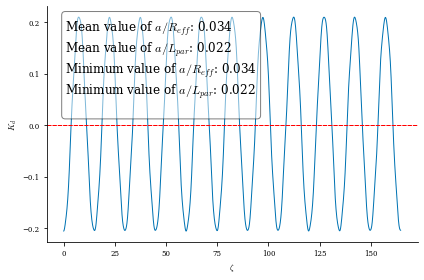

Values of R_eff are: [4.95346364 4.99643236 4.95395597 4.91346836 4.93973901]
Values of L_par are: [7.70731608 7.55765946 7.48283114 7.48283114 7.33317452]


In [10]:
plot_Kd(eq);

### Running a single optimization, targeting only one mode number ###

Here we run a single optimization targeting k=3 modes only, with weights of 10 for both quasisymmetry and aspect ratio

In [11]:
k = 3
qs_weight = 10
ar_weight = 10
eq_test = eq.copy()
eq_opt = run_step_weights(
    k=k,
    eq=eq_test,
    target=True,
    qs_weight=qs_weight,
    ar_weight=ar_weight,
    )

/tmp/ipykernel_305466/3473964650.py:41: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 716 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 185 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 36.7 ms
Timer: Objective build = 1.43 sec
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 619 ms
Timer: Objective build = 680 ms
Timer: Proximal projection build = 9.30 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 491 ms
Timer: Linear constraint projection build = 2.73 sec
Number of parameters: 24
Number of objectives: 1689
Timer: Initializing the optimization = 12.6 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0            

### Checking and comparing the output ###

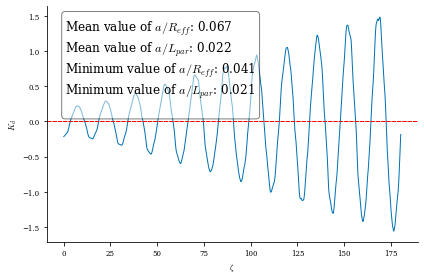

Values of R_eff are: [4.08859434 3.0032118  2.20853264 1.74587684 1.45076299]
Values of L_par are: [8.02996218 8.02996218 7.78414701 7.78414701 7.45639346]


In [12]:
plot_Kd(eq_opt);

In [13]:
check_force_error(eq_opt)

eq error: 0.03%


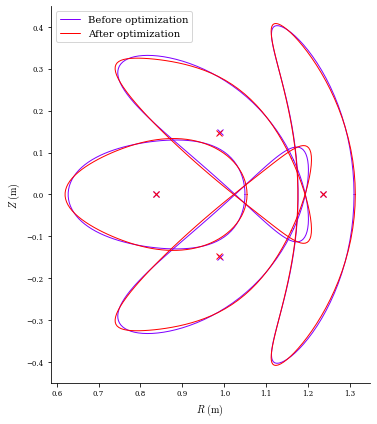

In [14]:
plot_boundaries(
    [eq,eq_opt],
    ["Before optimization", "After optimization"]
);

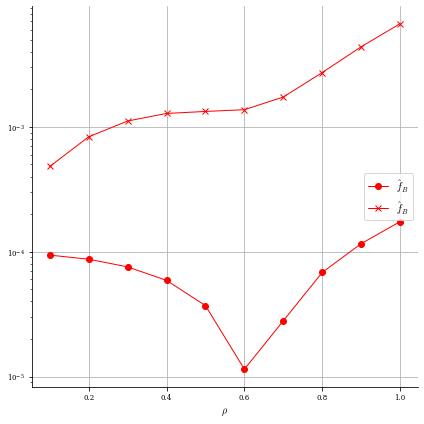

In [15]:
fig_qs_error, ax = plot_qs_error(
eq,
helicity=(1, 0),
fT=False,
fC=False,
legend=False,
rho=10,
);
plot_qs_error(
eq_opt, helicity=(1, 0), fT=False, fC=False, ax=ax, marker=["x"], rho=10
);
ax.grid()

### Running a single optimization, continuation method ###

In [16]:
k=2
qs_weight = 10
ar_weight = 10
eq_test = eq.copy()
eq_opt_fam, eq_opt = run_steps(
    eq=eq_test,
    modes=k,
    qs_weight=qs_weight,
    )

/tmp/ipykernel_305466/1672618710.py:42: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms


Timer: Precomputing transforms = 65.6 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 157 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 36.5 ms
Timer: Objective build = 206 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 71.8 ms
Timer: Objective build = 86.2 ms
Timer: Proximal projection build = 1.25 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 283 ms
Timer: Linear constraint projection build = 2.09 sec
Number of parameters: 8
Number of objectives: 1689
Timer: Initializing the optimization = 3.74 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.509e+01                                  

/tmp/ipykernel_305466/1672618710.py:42: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 67.8 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 145 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 36.7 ms
Timer: Objective build = 252 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 73.4 ms
Timer: Objective build = 87.4 ms
Timer: Proximal projection build = 2.16 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 240 ms
Timer: Linear constraint projection build = 1.71 sec
Number of parameters: 24
Number of objectives: 1689
Timer: Initializing the optimization = 4.18 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0           

### Running multiple optimizations ###

In [17]:
def run_all_experiments(eq, weight_combinations):
    """
    Run a series of optimizations for each weight combination, including mode number, and store results.

    Parameters:
    - eq: Initial DESC equilibrium object.
    - weight_combinations: List of (mode_number, qs_weight, aspect_ratio_weight) tuples.
    - maxiter: Maximum number of iterations for each optimization.

    Returns:
    - eqfam: EquilibriaFamily containing optimized equilibrium objects.
    - results_df: Pandas DataFrame containing the weight values and mode number for each run.
    """
    eqfam = EquilibriaFamily(eq)  # Initialize with initial equilibrium
    results = []  # List to store weight values for each experiment

    for mode, qs_weight, ar_weight in weight_combinations:
        eq_test = eq.copy()
        try:
            # Run optimization for each weight combination, using mode as k
            eq_new = run_step_weights(
                k=mode,  # Use mode number as k directly
                eq=eq_test,
                target=True,
                qs_weight=qs_weight,
                ar_weight=ar_weight,
                n_wells=5,
                n_pol=8,
            )
            # Append the new equilibrium to the family
            eqfam.append(eq_new)
            # Log the weight values and mode number
            results.append(
                {
                    "mode_number": mode,
                    "qs_weight": qs_weight,
                    "aspect_ratio_weight": ar_weight,
                    "status": "Success",
                }
            )
            print(
                f"Optimization successful for mode={mode}, qs_weight={qs_weight}, ar_weight={ar_weight}"
            )
        except Exception as e:
            print(
                f"Optimization failed for mode={mode}, qs_weight={qs_weight}, ar_weight={ar_weight}: {e}"
            )
            results.append(
                {
                    "mode_number": mode,
                    "qs_weight": qs_weight,
                    "aspect_ratio_weight": ar_weight,
                    "status": "Failed",
                }
            )

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return eqfam, results_df


In [18]:
weight_combinations = [
# n=2 mode
(2, 4, 4),
(2, 5, 5),
(2, 8, 8),
(2, 10, 10),
]
eq_test = eq.copy()
eq_fam,results_df = run_all_experiments(eq_test,weight_combinations)

/tmp/ipykernel_305466/3473964650.py:41: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms


Timer: Precomputing transforms = 71.9 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 159 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 37.8 ms
Timer: Objective build = 216 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 73.9 ms
Timer: Objective build = 88.4 ms
Timer: Proximal projection build = 1.33 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 307 ms
Timer: Linear constraint projection build = 2.54 sec
Number of parameters: 16
Number of objectives: 1689
Timer: Initializing the optimization = 4.30 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.509e+01                                 

/tmp/ipykernel_305466/3473964650.py:41: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 66.9 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 146 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 37.0 ms
Timer: Objective build = 210 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 73.3 ms
Timer: Objective build = 87.8 ms
Timer: Proximal projection build = 1.27 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 116 ms
Timer: Linear constraint projection build = 282 ms
Number of parameters: 16
Number of objectives: 1689
Timer: Initializing the optimization = 1.75 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0             

/tmp/ipykernel_305466/3473964650.py:41: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 66.5 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 142 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 36.8 ms
Timer: Objective build = 210 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 73.2 ms
Timer: Objective build = 87.8 ms
Timer: Proximal projection build = 1.27 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 118 ms
Timer: Linear constraint projection build = 285 ms
Number of parameters: 16
Number of objectives: 1689
Timer: Initializing the optimization = 1.75 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0             

/tmp/ipykernel_305466/3473964650.py:41: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 67.9 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 142 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 37.3 ms
Timer: Objective build = 216 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 74.5 ms
Timer: Objective build = 88.7 ms
Timer: Proximal projection build = 1.29 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 118 ms
Timer: Linear constraint projection build = 288 ms
Number of parameters: 16
Number of objectives: 1689
Timer: Initializing the optimization = 1.77 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0             

In [19]:
def print_results(eq_fam,results_df):
    eq_init = eq_fam[0]
    iota_grid = LinearGrid(rho=0.5)
    iota = jnp.abs(eq_init.compute("iota", iota_grid)["iota"][0])
    grid = get_field_line_grid(eq_init, iota, n_pol=11, rho=0.5)
    R_eff = eq_init.compute("R_eff", grid=grid, n_wells=5)["R_eff"]
    L_par = eq_init.compute("L_par", grid=grid, n_wells=5)["L_par"]
    a = get_value(eq_init, "a", grid)
    R_max = jnp.min(a/R_eff)
    L_max = jnp.min(a/L_par)
    R_mean = jnp.mean(a/R_eff)
    L_mean = jnp.mean(a/L_par)
    crit = jnp.min(a/R_eff+8*a/L_par)
    print(f"Initial equilibrium, (a/R)_min = {R_max:.3f}, (a/L)_min = {L_max:.3f}, (a/R)_mean = {R_mean:.3f}, (a/L)_mean = {L_mean:.3f}, crit = {crit:.3f}")
    for i in range(len(eq_fam)-1):
        iota_grid = LinearGrid(rho=0.5)
        eq = eq_fam[i+1]
        iota = jnp.abs(eq.compute("iota", iota_grid)["iota"][0])
        grid = get_field_line_grid(eq, iota, n_pol=11, rho=0.5)
        R_eff = eq.compute("R_eff", grid=grid, n_wells=5)["R_eff"]
        L_par = eq.compute("L_par", grid=grid, n_wells=5)["L_par"]
        a = get_value(eq, "a", grid)
        R_max = jnp.min(a/R_eff)
        L_max = jnp.min(a/L_par)
        R_mean = jnp.mean(a/R_eff)
        L_mean = jnp.mean(a/L_par)
        crit = jnp.min(a/R_eff+8*a/L_par)
        mode = results_df.iloc[i]["mode_number"]
        qs_weight = results_df.iloc[i]["qs_weight"]
        ar_weight = results_df.iloc[i]["aspect_ratio_weight"]
        print(f"Mode: {mode}, qs_weight: {qs_weight}, ar_weight: {ar_weight}, (a/R)_min = {R_max:.3f}, (a/L)_max = {L_max:.3f}, (a/R)_mean = {R_mean:.3f}, (a/L)_mean = {L_mean:.3f}, crit = {crit:.3f}")


In [20]:
print_results(eq_fam,results_df)

Initial equilibrium, (a/R)_min = 0.034, (a/L)_min = 0.022, (a/R)_mean = 0.034, (a/L)_mean = 0.022, crit = 0.209
Mode: 2, qs_weight: 4, ar_weight: 4, (a/R)_min = 0.038, (a/L)_max = 0.018, (a/R)_mean = 0.057, (a/L)_mean = 0.019, crit = 0.186
Mode: 2, qs_weight: 5, ar_weight: 5, (a/R)_min = 0.038, (a/L)_max = 0.019, (a/R)_mean = 0.055, (a/L)_mean = 0.019, crit = 0.187
Mode: 2, qs_weight: 8, ar_weight: 8, (a/R)_min = 0.038, (a/L)_max = 0.019, (a/R)_mean = 0.050, (a/L)_mean = 0.019, crit = 0.191
Mode: 2, qs_weight: 10, ar_weight: 10, (a/R)_min = 0.037, (a/L)_max = 0.019, (a/R)_mean = 0.044, (a/L)_mean = 0.019, crit = 0.188


### Run multiple continuation type optimizations ###

In [21]:
def run_all_experiments_combined(eq, weight_combinations, max_mode = 2):
    """
    Run a series of optimizations for each weight combination, including mode number, and store results.

    Parameters:
    - eq: Initial DESC equilibrium object.
    - weight_combinations: List of (mode_number, qs_weight, aspect_ratio_weight) tuples.
    - maxiter: Maximum number of iterations for each optimization.

    Returns:
    - eqfam: EquilibriaFamily containing optimized equilibrium objects.
    - results_df: Pandas DataFrame containing the weight values and mode number for each run.
    """
    eqfam = EquilibriaFamily(eq)  # Initialize with initial equilibrium
    results = []  # List to store weight values for each experiment

    for qs_weight, ar_weight in weight_combinations:
        eq_test = eq.copy()
        try:
            # Run optimization for each weight combination, using mode as k
            _,eq_new = run_steps(
                eq_test,
                modes=max_mode,
                target=False,
                qs_weight=qs_weight,
                ar_weight=ar_weight,
                n_wells=5,
                n_pol=8
            )
            # Append the new equilibrium to the family
            eqfam.append(eq_new)
            # Log the weight values and mode number
            results.append(
                {
                    "qs_weight": qs_weight,
                    "aspect_ratio_weight": ar_weight,
                    "status": "Success",
                }
            )
            print(
                f"Optimization successful for qs_weight={qs_weight}, ar_weight={ar_weight}"
            )
        except Exception as e:
            print(
                f"Optimization failed for qs_weight={qs_weight}, ar_weight={ar_weight}: {e}"
            )
            results.append(
                {
                    "qs_weight": qs_weight,
                    "aspect_ratio_weight": ar_weight,
                    "status": "Failed",
                }
            )

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return eqfam, results_df


In [22]:
eq_test = eq.copy()
weight_combinations = [
    # n = 2 mode
    # (4, 10),  Be careful, this one gives errors because of the creation of little wells which make the effective 
    # radius calulcation impossible, this needs to be be fixed    
    (5, 8),
    (8, 5),
    (10, 8),(10,10)
]
eq_fam, results_df = run_all_experiments_combined(eq_test,weight_combinations)

/tmp/ipykernel_305466/1672618710.py:42: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 70.0 ms
Building objective: Effective radius


Precomputing transforms
Timer: Precomputing transforms = 134 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 36.5 ms
Timer: Objective build = 211 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 72.1 ms
Timer: Objective build = 86.6 ms
Timer: Proximal projection build = 1.27 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 116 ms
Timer: Linear constraint projection build = 291 ms
Number of parameters: 8
Number of objectives: 1689
Timer: Initializing the optimization = 1.75 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1          1.509e+01                                    2.757e+02   
       1              2          1.409e+01      9.961e-01      1.

/tmp/ipykernel_305466/1672618710.py:42: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 67.1 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 138 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 36.5 ms
Timer: Objective build = 209 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 73.6 ms
Timer: Objective build = 88.9 ms
Timer: Proximal projection build = 1.26 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 117 ms
Timer: Linear constraint projection build = 218 ms
Number of parameters: 24
Number of objectives: 1689
Timer: Initializing the optimization = 1.66 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0             

/tmp/ipykernel_305466/1672618710.py:42: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 67.8 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 138 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 37.4 ms
Timer: Objective build = 212 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 74.6 ms
Timer: Objective build = 88.6 ms
Timer: Proximal projection build = 1.30 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 118 ms
Timer: Linear constraint projection build = 286 ms
Number of parameters: 8
Number of objectives: 1689
Timer: Initializing the optimization = 1.78 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              

/tmp/ipykernel_305466/1672618710.py:42: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 67.7 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 138 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 37.2 ms
Timer: Objective build = 210 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 80.6 ms
Timer: Objective build = 95.6 ms
Timer: Proximal projection build = 1.23 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 119 ms
Timer: Linear constraint projection build = 223 ms
Number of parameters: 24
Number of objectives: 1689
Timer: Initializing the optimization = 1.64 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0             

/tmp/ipykernel_305466/1672618710.py:42: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 68.6 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 171 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 38.3 ms
Timer: Objective build = 214 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 74.7 ms
Timer: Objective build = 89.5 ms
Timer: Proximal projection build = 1.24 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 118 ms
Timer: Linear constraint projection build = 283 ms
Number of parameters: 8
Number of objectives: 1689
Timer: Initializing the optimization = 1.72 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              

/tmp/ipykernel_305466/1672618710.py:42: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 69.1 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 139 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 37.0 ms
Timer: Objective build = 212 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 74.6 ms
Timer: Objective build = 89.2 ms
Timer: Proximal projection build = 1.20 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 117 ms
Timer: Linear constraint projection build = 221 ms
Number of parameters: 24
Number of objectives: 1689
Timer: Initializing the optimization = 1.60 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0             

/tmp/ipykernel_305466/1672618710.py:42: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 68.3 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 136 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 37.7 ms
Timer: Objective build = 212 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 74.8 ms
Timer: Objective build = 88.3 ms
Timer: Proximal projection build = 1.26 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 115 ms
Timer: Linear constraint projection build = 278 ms
Number of parameters: 8
Number of objectives: 1689
Timer: Initializing the optimization = 1.73 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              

/tmp/ipykernel_305466/1672618710.py:42: DeprecationWarning: vstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  R_modes = jnp.vstack(


Building objective: QS two-term
Precomputing transforms
Timer: Precomputing transforms = 66.8 ms
Building objective: Effective radius
Precomputing transforms
Timer: Precomputing transforms = 143 us
Building objective: aspect ratio
Precomputing transforms
Timer: Precomputing transforms = 36.9 ms
Timer: Objective build = 208 ms
Building objective: force
Precomputing transforms
Timer: Precomputing transforms = 73.6 ms
Timer: Objective build = 88.3 ms
Timer: Proximal projection build = 1.19 sec
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed Psi
Timer: Objective build = 118 ms
Timer: Linear constraint projection build = 221 ms
Number of parameters: 24
Number of objectives: 1689
Timer: Initializing the optimization = 1.60 sec

Starting optimization
Using method: proximal-lsq-exact
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0             

### Comparison plots ###

In [23]:
def plot_Kd_family(eqfam, results_df, n_pol=11, rho=0.5, n_wells=5):
    """
    Plot Kd for each equilibrium in the family, including the initial equilibrium,
    with up to 4 plots per row.

    Parameters:
    - eqfam: EquilibriaFamily containing all optimized equilibrium objects, including the initial one.
    - results_df: DataFrame containing weight values for each run, including mode number.
    - n_pol: Number of poloidal turns for the Kd calculation.
    - rho: Radius in normalized coordinates.
    - n_wells: Number of wells for effective radius optimization.
    """
    num_plots = len(eqfam.equilibria) - 1  # Include the initial equilibrium
    if num_plots <= 0:
        print("No equilibria to plot.")
        return

    # Set 4 plots per row
    num_cols = 4
    num_rows = int(jnp.ceil(num_plots / num_cols))

    # Create the figure with the appropriate number of subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 4 * num_rows))
    fig.suptitle("Kd Plots for Optimized Equilibria", fontsize=16)

    # Flatten the axs array for easy iteration
    axs = axs.flatten()

    # Iterate over equilibria and corresponding weights
    for i, (eq, ax) in enumerate(zip(eqfam.equilibria[1:], axs)):
        if i < len(results_df):  # Ensure that there are weights for this equilibrium
            # mode = results_df.iloc[i]["mode_number"]
            mode = 12 # For the continutation method, otherwise uncomment line above and comment this one
            qs_weight = results_df.iloc[i]["qs_weight"]
            ar_weight = results_df.iloc[i]["aspect_ratio_weight"]
            title = f"Mode: {mode}, QS: {qs_weight}, AR: {ar_weight}"
            ax.set_title(title)

            # Calculate and plot Kd
            iota_grid = LinearGrid(rho=rho)
            iota = jnp.abs(eq.compute("iota", iota_grid)["iota"][0])
            grid = get_field_line_grid(eq, iota, n_pol=n_pol, rho=rho)
            Kd = get_value(eq, "Kd", grid)
            ax.plot(grid.nodes[:, 2], Kd)
            ax.axhline(0, color="r", linestyle="--")
            ax.set_xlabel(r"$\zeta$")
            ax.set_ylabel(r"$K_d$")

            # Calculate R_eff and L_par for displaying in the text box
            R_eff = eq.compute("R_eff", grid=grid, n_wells=n_wells)["R_eff"]
            L_par = eq.compute("L_par", grid=grid, n_wells=n_wells)["L_par"]
            a = get_value(eq, "a", grid)

            # Format the text to be displayed in the box
            textstr = (
                f"Mean $a/R_{{eff}}$: {a/R_eff.mean():.3f}\n"
                f"Mean $a/L_{{par}}$: {a/L_par.mean():.3f}\n"
                f"Min $a/R_{{eff}}$: {a/R_eff.max():.3f}\n"
                f"Min $a/L_{{par}}$: {a/L_par.max():.3f}\n"
            )

            # Add the text box to the plot
            props = dict(boxstyle="round", facecolor="white", alpha=0.5)
            ax.text(
                0.05,
                0.95,
                textstr,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment="top",
                bbox=props,
            )
            ax.grid()
        else:
            ax.axis("off")  # Turn off axes if there are more subplots than equilibria

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
    plt.show()


In [37]:
def plot_boozer_family(eqfam, results_df, rho=0.5, fill=False, ncontours=30, fieldlines=0):
    """
    Plot quasisymmetry for each equilibrium in the family, with a dynamic number of subplots.

    Parameters:
    - eqfam: EquilibriaFamily containing all optimized equilibrium objects.
    - results_df: DataFrame containing weight values for each run.
    - rho: Radius in normalized coordinates.
    - fill: Whether the contours are filled, i.e., whether to use `contourf` or `contour`.
    - ncontours: Number of contours to plot.
    - fieldlines: Number of (linearly spaced) magnetic fieldlines to plot. Default is 0 (none).
    """
    num_plots = len(eqfam.equilibria) - 1  # Exclude the initial equilibrium
    if num_plots <= 0:
        print("No equilibria to plot.")
        return

    # Determine the number of rows and columns dynamically
    num_cols = 4
    num_rows = int(jnp.ceil(num_plots / num_cols))

    # Create the figure with the appropriate number of subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 4 * num_rows))
    fig.suptitle("Quasisymmetry Plots for Optimized Equilibria", fontsize=16)

    # Flatten the axs array for easy iteration
    axs = axs.flatten()

    # Iterate over equilibria and corresponding weights
    for i, (eq, ax) in enumerate(zip(eqfam.equilibria[1:], axs)):
        if i < len(results_df):  # Ensure we have weights for this equilibrium
            qs_weight = results_df.iloc[i]["qs_weight"]
            aspect_ratio_weight = results_df.iloc[i]["aspect_ratio_weight"]
            title = f"qs_weight: {qs_weight:.2f}, ar_weight: {aspect_ratio_weight:.2f}"
            ax.set_title(title)

            # Plot Boozer surface for the current equilibrium
            plot_boozer_surface(
                eq,
                rho=rho,
                fill=fill,
                ncontours=ncontours,
                fieldlines=fieldlines,
                ax=ax,
            )

            # Optionally, you can add additional calculated values to the text box
            textstr = (
                f"qs_weight: {qs_weight:.2f}\n"
                f"ar_weight: {aspect_ratio_weight:.2f}\n"
            )

            # Add the text box to the plot
            props = dict(boxstyle="round", facecolor="white", alpha=0.5)
            ax.text(
                0.05,
                0.95,
                textstr,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment="top",
                bbox=props,
            )

            ax.grid()
        else:
            ax.axis("off")  # Turn off axes if there are more subplots than equilibria

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
    plt.show()


In [36]:
def plot_quasisymmetry_error_family(eqfam, results_df):
    """
    Plot quasisymmetry error for each equilibrium in the family with a dynamic number of subplots.

    Parameters:
    - eqfam: EquilibriaFamily containing all optimized equilibrium objects.
    - results_df: DataFrame containing weight values for each run.
    """
    num_plots = len(eqfam.equilibria) - 1  # Exclude the initial equilibrium
    if num_plots <= 0:
        print("No equilibria to plot.")
        return

    # Determine the number of rows and columns dynamically
    num_cols = 4
    num_rows = int(jnp.ceil(num_plots / num_cols))

    # Create the figure with the appropriate number of subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 4 * num_rows))
    fig.suptitle("Quasisymmetry Error for Optimized Equilibria", fontsize=16)

    # Flatten the axs array for easy iteration
    axs = axs.flatten()

    eq_initial = eqfam[0]

    # Iterate over equilibria and corresponding weights
    for i, (eq, ax) in enumerate(zip(eqfam.equilibria[1:], axs)):
        if i < len(results_df):  # Ensure we have weights for this equilibrium
            qs_weight = results_df.iloc[i]["qs_weight"]
            aspect_ratio_weight = results_df.iloc[i]["aspect_ratio_weight"]
            title = f"qs_weight: {qs_weight:.2f}, ar_weight: {aspect_ratio_weight:.2f}"
            ax.set_title(title)

            # Plot QS error for eq_initial and the current equilibrium
            plot_qs_error(
                eq_initial,
                helicity=(1, 0),
                fT=False,
                fC=False,
                legend=False,
                rho=10,
                ax=ax,
            )
            plot_qs_error(
                eq, helicity=(1, 0), fT=False, fC=False, ax=ax, marker=["x"], rho=10
            )

            # Add the weight information in a text box
            textstr = (
                f"qs_weight: {qs_weight:.2f}\n"
                f"ar_weight: {aspect_ratio_weight:.2f}\n"
            )

            # Create a text box with the weight information
            props = dict(boxstyle="round", facecolor="white", alpha=0.5)
            ax.text(
                0.05,
                0.95,
                textstr,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment="top",
                bbox=props,
            )

            ax.grid()
        else:
            ax.axis("off")  # Turn off axes if there are more subplots than equilibria

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
    plt.show()


In [34]:
def plot_boundaries_family(eqfam, results_df, rho=0.5, fill=False, ncontours=30, fieldlines=0):
    """
    Plot quasisymmetry boundaries for each equilibrium in the family with a dynamic number of subplots.

    Parameters:
    - eqfam: EquilibriaFamily containing all optimized equilibrium objects.
    - results_df: DataFrame containing weight values for each run.
    - rho: Radius in normalized coordinates.
    - fill: Whether the contours are filled, i.e. whether to use `contourf` or `contour`.
    - ncontours: Number of contours to plot.
    - fieldlines: Number of (linearly spaced) magnetic fieldlines to plot. Default is 0 (none).
    """
    num_plots = len(eqfam.equilibria) - 1  # Exclude the initial equilibrium
    if num_plots <= 0:
        print("No equilibria to plot.")
        return

    # Determine the number of rows and columns dynamically
    num_cols = 4
    num_rows = int(jnp.ceil(num_plots / num_cols))

    # Create the figure with the appropriate number of subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 4 * num_rows))
    fig.suptitle("Quasisymmetry Plots for Optimized Equilibria", fontsize=16)

    # Flatten the axs array for easy iteration
    axs = axs.flatten()

    eq_initial = eqfam[0]

    # Iterate over equilibria and corresponding weights
    for i, (eq, ax) in enumerate(zip(eqfam.equilibria[1:], axs)):
        if i < len(results_df):  # Ensure we have weights for this equilibrium
            qs_weight = results_df.iloc[i]["qs_weight"]
            aspect_ratio_weight = results_df.iloc[i]["aspect_ratio_weight"]
            title = f"qs_weight: {qs_weight:.2f}, ar_weight: {aspect_ratio_weight:.2f}"
            ax.set_title(title)

            # Plot boundaries for the initial and current equilibrium
            plot_boundaries(
                eqs=[eq_initial, eq],
                labels=["Before optimization", "After optimization"],
                ax=ax,
            )

            # Add the text box to the plot
            textstr = (
                f"qs_weight: {qs_weight:.2f}\n"
                f"ar_weight: {aspect_ratio_weight:.2f}\n"
            )
            props = dict(boxstyle="round", facecolor="white", alpha=0.5)
            ax.text(
                0.05,
                0.95,
                textstr,
                transform=ax.transAxes,
                fontsize=10,
                verticalalignment="top",
                bbox=props,
            )

            # Optionally add custom plot features
            ax.axhline(0, color="r", linestyle="--")
        else:
            ax.axis("off")  # Turn off unused subplots

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout
    plt.show()


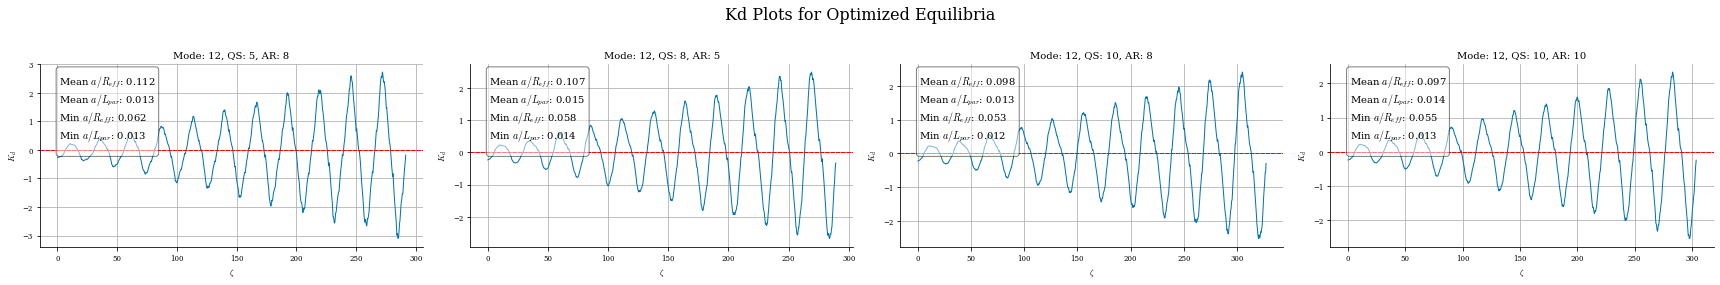

In [27]:
plot_Kd_family(eq_fam,results_df)

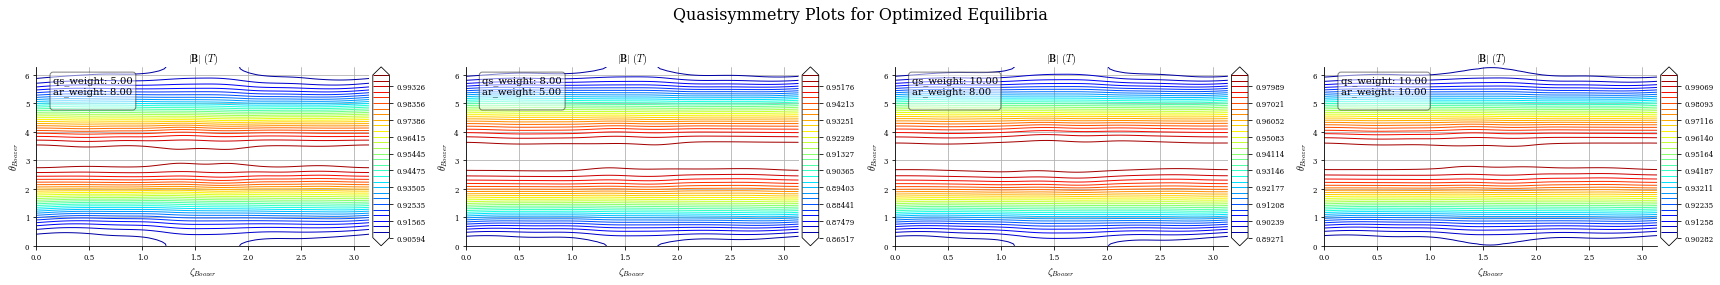

In [38]:
plot_boozer_family(eq_fam,results_df)

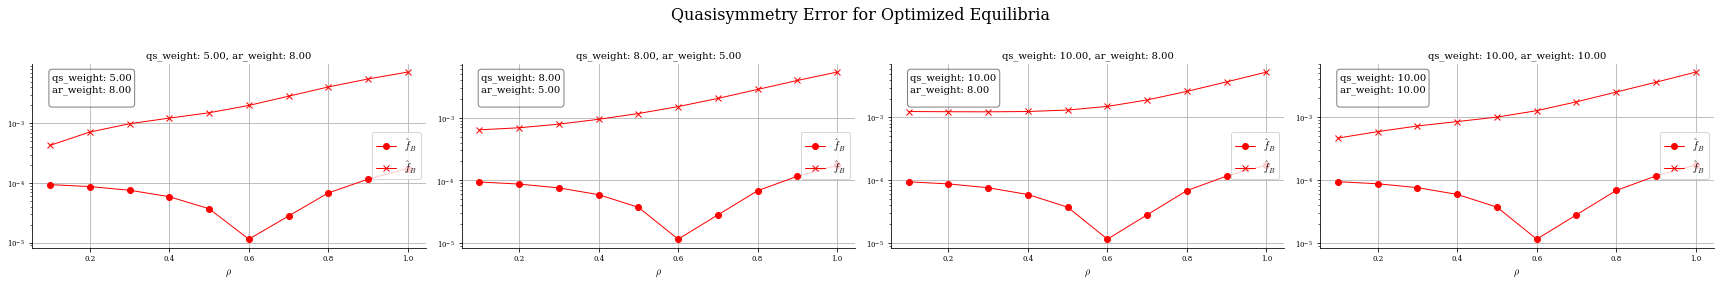

In [39]:
plot_quasisymmetry_error_family(eq_fam,results_df)

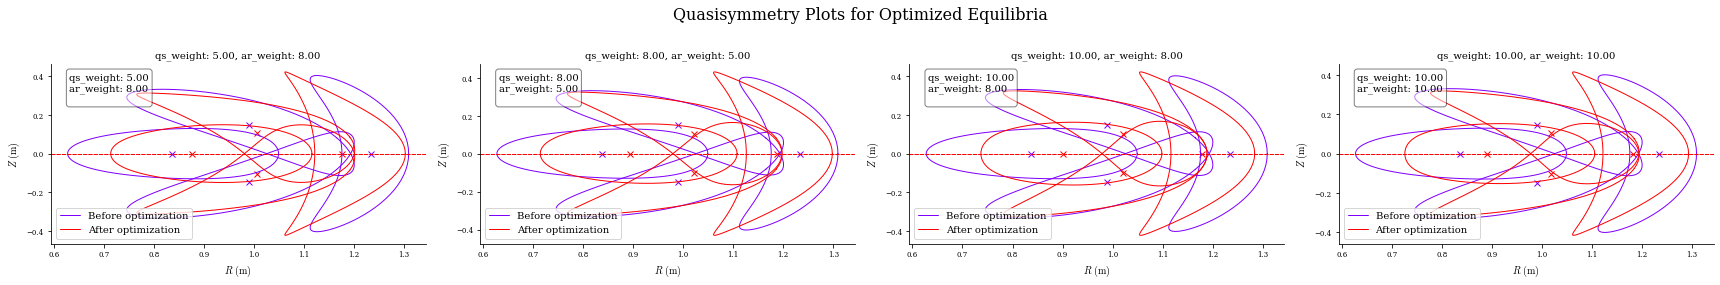

In [35]:
plot_boundaries_family(eq_fam,results_df)

## Saving data for GX runs ##

Modify path locations and uncomment lines

In [31]:
# path = "/global/homes/j/jjfrybes/DESC/local/precise_QA_tests/mode_4/"
# eq_fam.save(path+"precise_QA_outputs_mode_4.h5")
# results_df.to_pickle(path+'precise_QA_mode_4_dataframe.pkl')

In [32]:
def save_eqs(eq_fam,results_df):
    for i in range(len(eq_fam)-1):
        eq = eq_fam[i+1]
        mode = results_df.iloc[i]["mode_number"]
        # mode = 12     If running the continuation method, no mode value is assigned, so we have to set it
        qs_weight = results_df.iloc[i]["qs_weight"]
        ar_weight = results_df.iloc[i]["aspect_ratio_weight"]
        path = "/global/homes/j/jjfrybes/DESC/local/precise_QA_tests/mode_4/"
        filename = "wout_precise_QA" + "_" + str(mode) + "_" + str(qs_weight) + "_" + str(ar_weight) + ".nc"
        VMECIO.save(eq,path+filename)

In [33]:
# save_eqs(eq_fam,results_df)